# Modeling
In this notebook I will create some deep learning models to address the colorization task.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import json

import tensorflow as tf

from tensorflow import keras

from keras.layers import Conv2D, UpSampling2D, Dense, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

from sklearn.model_selection import train_test_split

from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave, imshow

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


In [4]:
dataset_path = "../preprocessed/"
path = '../dataset/'
models_path = "../models/"
results_path = "../results/"
history_path = "../models/history/"

In [5]:
SIZE = 128

### Image Size Problem
The literature addresses the colorization problem with rescaled images typically of size $256\times256$. However, due to limitated resources and time, I had to lower the number of input pixels to $128\times128$.

The difference in training time is quite large and it would be impossibile in a reasonable amount of time to test different model architecture an correctly validate some hyper-parameters.

Literature image input size: $$256\times256 = 2^8\times2^8 = 2^{16}$$

My lower image input size: $$128\times128 = 2^7\times2^7 = 2^{14}$$

There is a difference of $4$ times between the two image resolutions and this enables me to run $4$ times the number of test in order to validate my models. Eventually, once I found the best model, I will train it with the full $256\times256$ resolution, in order to compare to previous methods.

I know it is not an optimal procedure but I had to face time, memory and computational constraints.

## Pre-processing

In [129]:
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255)

#Resize images, if needed
train = train_datagen.flow_from_directory(path+"download/", 
                                          target_size=(SIZE, SIZE), 
                                          batch_size=1000, 
                                          class_mode=None)

Found 1000 images belonging to 1 classes.


In [130]:
#Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to Lab. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.
"""

X =[]
Y =[]
for img in tqdm(train[0]):
    try:
        lab = rgb2lab(img)
        X.append(lab[:,:,0]) 
        Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
        #so we divide the values by 128 to restrict values to between -1 and 1.
    except:
        print('error')
        
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) # dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

100%|██████████| 1000/1000 [00:03<00:00, 302.86it/s]


(1000, 128, 128, 1)
(1000, 128, 128, 2)


In [125]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2) # split between train+valid / test
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2) # split between train / valid
print("Train",X_train.shape, Y_train.shape)
print("Valid",X_valid.shape, Y_valid.shape)
print("Test",X_test.shape, Y_test.shape)

Train (640, 128, 128, 1) (640, 128, 128, 2)
Valid (160, 128, 128, 1) (160, 128, 128, 2)
Test (200, 128, 128, 1) (200, 128, 128, 2)


## Training

### v0 - Deep Dense AutoEncoder

This model is not powerful enough to reproduce the task of colorization.
With less than 85k trainable parameters, a simple deep autoencoder with only dense layers is not a valid option.

More important, I can clearly see that this model is not suitable for this task because even with a small dataset (100 images) and lots of epochs (50) it is not able to overfit the training data.

In [46]:
# Encoder
model = Sequential(name=("AE_Simple_Dense"))
model.add(Dense(128,activation="relu", input_shape=(SIZE, SIZE, 1)))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))

# Decoder
model.add(Dense(64,activation="relu"))
model.add(Dense(128,activation="relu"))

# output layer
model.add(Dense(2, activation='tanh'))

### v1 - Deep Conv AutoEncoder

In order to increase the power of the hidden state representation I used 2D convolutional layers instead of dense layers.

This autoencoder has almost the same number of filters compared to number of neurons of the previous simple dense autoencoder.

```javascript
Test loss: 0.011212530545890331 accuracy: 0.7764270305633545
```

In [9]:
#Encoder
model = Sequential(name=("AE_Simple_Conv"))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))

#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))          

# output layer
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

### v2 - Deep Conv Dense AutoEncoder

In order to increase the power of the hidden state representation I used 2D convolutional layers instead of dense layers.

This autoencoder has the same number of filters compared to number of neurons of the previous simple dense autoencoder.

In [32]:
#Encoder
model = Sequential(name=("AE_Conv_Dense"))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

#Decoder
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))          

# output layer
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

### v3 - Complex Deep AutoEncoder
```javascript
Test loss: 0.0024387992452830076 accuracy: 0.8990771770477295
```

In [38]:
#Encoder
model = Sequential(name=("AE_Complex"))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(SIZE, SIZE, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

#Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

### v4 - Polychromify
Only upsampling
```javascript
Test loss: 0.0019184787524864078 accuracy: 0.8854940533638
```

Dense layers
```javascript
Test loss: 0.0020508132874965668 accuracy: 0.8778021335601807
```

v2
```javascript
Test loss: 0.0021823025308549404 accuracy: 0.8989642262458801
```

v3 (1 dense 128)
```javascript
Validation loss: 0.0021823025308549404 accuracy: 0.8989642262458801
```

v4 (4 dense 128-256-256-128)
```javascript
Validation loss: 0.003157110419124365 accuracy: 0.8902606964111328
```

v4.1 (conv 32-->1024)
```javascript
Validation loss: 0.0022339080460369587 accuracy: 0.8981853723526001
```

In [111]:
#Encoder
model = Sequential(name=("Polychromify-v4"))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2, input_shape=(SIZE, SIZE, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))


#Decoder
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

# Output layer
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

### Hyper-parameter selection

Related to model architecture
- number of layers
- conv vs no-conv
- upsampling y/n
- maxpool y/n

Related to training
- epochs **[50-75-100]**
- validation split **[0.2 fixed]**
- batch size **[16 fixed]**

In [114]:
model.compile(optimizer="adam", loss='mse' , metrics=['accuracy'])
model.summary()

Model: "Polychromify-v4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_155 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 4, 4, 512)         1180160   
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 4, 4, 1024)        4719616   
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 4, 4, 512)     

In [115]:
history = model.fit(X_train[:100],Y_train[:100],validation_data=(X_valid[:100], Y_valid[:100]), epochs=50, batch_size=16)

Epoch 1/50
7/7 [==============================] - 8s 838ms/step - loss: 0.0128 - accuracy: 0.6713 - val_loss: 0.0141 - val_accuracy: 0.4619
Epoch 2/50
7/7 [==============================] - 5s 769ms/step - loss: 0.0134 - accuracy: 0.5376 - val_loss: 0.0143 - val_accuracy: 0.6642
Epoch 3/50
7/7 [==============================] - 5s 745ms/step - loss: 0.0135 - accuracy: 0.5521 - val_loss: 0.0141 - val_accuracy: 0.4071
Epoch 4/50
7/7 [==============================] - 5s 758ms/step - loss: 0.0134 - accuracy: 0.4907 - val_loss: 0.0141 - val_accuracy: 0.3353
Epoch 5/50
7/7 [==============================] - 5s 741ms/step - loss: 0.0132 - accuracy: 0.3421 - val_loss: 0.0140 - val_accuracy: 0.6353
Epoch 6/50
7/7 [==============================] - 5s 741ms/step - loss: 0.0134 - accuracy: 0.6279 - val_loss: 0.0140 - val_accuracy: 0.6762
Epoch 7/50
7/7 [==============================] - 5s 778ms/step - loss: 0.0133 - accuracy: 0.6665 - val_loss: 0.0141 - val_accuracy: 0.6662
Epoch 8/50
7/7 [====

### History plots

In [116]:
def plot_history(history,model_name=model.name):
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    ax = axes.ravel()

    # accuracy
    ax[0].plot(history['accuracy'])
    ax[0].plot(history['val_accuracy'])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].legend(['train', 'validation'], loc='upper left')

    # summarize history for loss
    ax[1].plot(history['loss'])
    ax[1].plot(history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epochs')
    ax[1].legend(['train', 'validation'], loc='upper right')

    fig.tight_layout()
    fig.suptitle(model.name,fontsize=16)
    plt.show()      

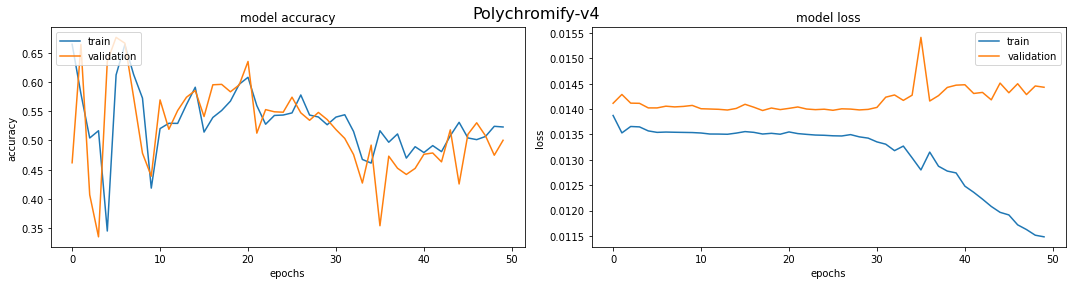

In [117]:
plot_history(history.history,model.name)

In [118]:
valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, batch_size=16, verbose=0)

print(f"Validation loss: {valid_loss} accuracy: {valid_acc}")

Validation loss: 0.014355948194861412 accuracy: 0.5044639706611633


### Save model+history to disk

In [101]:
json.dump(history.history, open(history_path+model.name+".json", 'w'))
model.save(models_path+model.name)

INFO:tensorflow:Assets written to: ../models/Polychromify-v4\assets


---

### Load model+history from disk

In [44]:
# choose model to load
model_name = model.name
# model_name = "colorize_autoencoder_VGG16_10000.model"

In [45]:
# loads a model from disk into memory
model = tf.keras.models.load_model(
    models_path+model_name,
    custom_objects=None,
    compile=True)

In [189]:
history_loaded = json.load(open(history_path+model.name+".json", 'r'))   

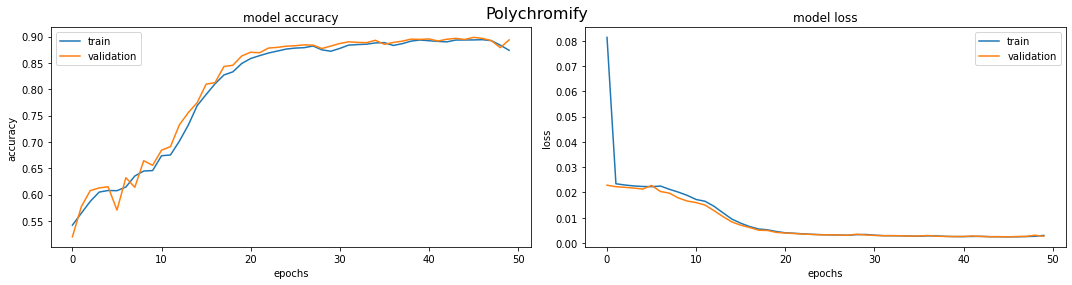

In [217]:
plot_history(history_loaded,model.name)

## Testing

Final model testing.

> I do **not** validate on this set, the following metrics are just meant to be _reported_ and not used as indicators.

In this phase I will also compare some other algorithms.

In [119]:
test_loss, test_acc = model.evaluate(X_test, Y_test, batch_size=16, verbose=0)

print(f"Test loss: {test_loss} accuracy: {test_acc}")

Test loss: 0.01451557781547308 accuracy: 0.5073162913322449


## Visualization

In [51]:
def plot_comparison(img_resized,img_recolored, figsize=(10,5),cast=False):     
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    ax = axes.ravel()

    ax[0].imshow(img_resized.astype('uint8') if cast else img_resized)
    ax[0].set_title("Resized")
    
    ax[1].imshow(img_recolored)
    ax[1].set_title("Recolored")

    fig.tight_layout()
    plt.show()      

### Visualization from test set

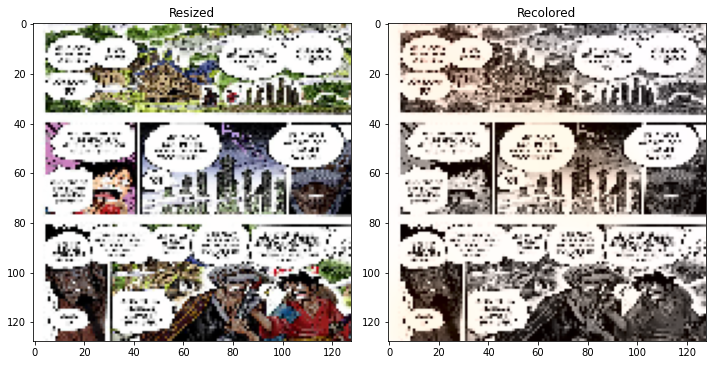

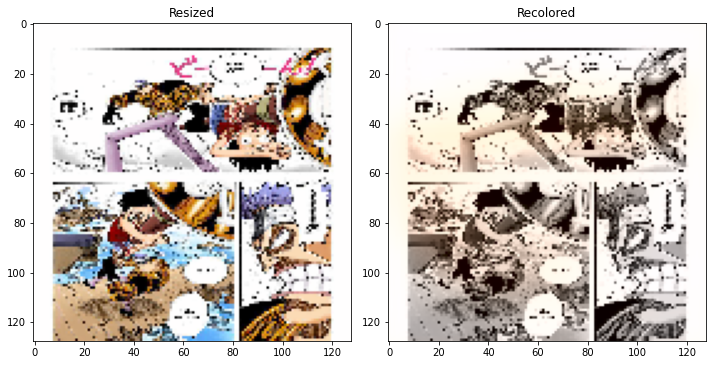

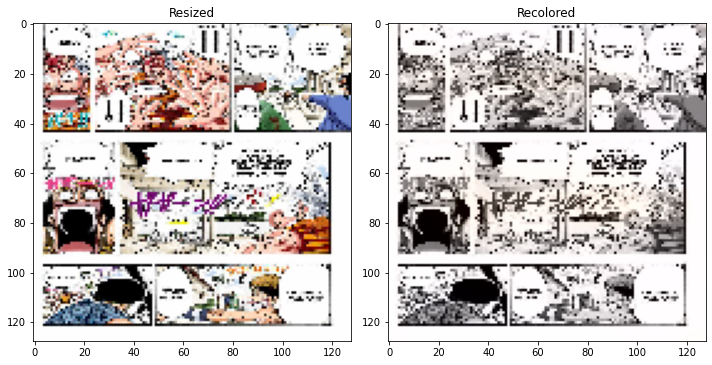

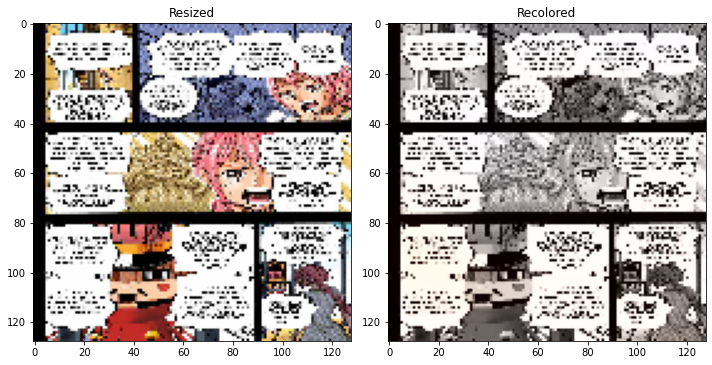

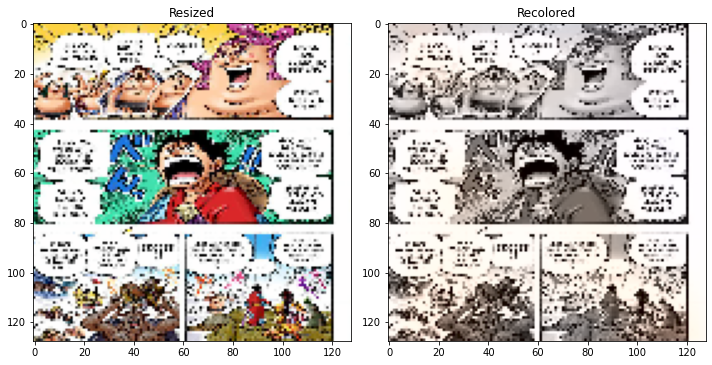

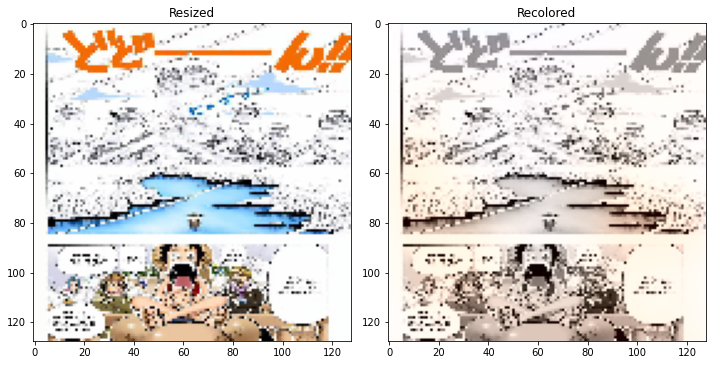

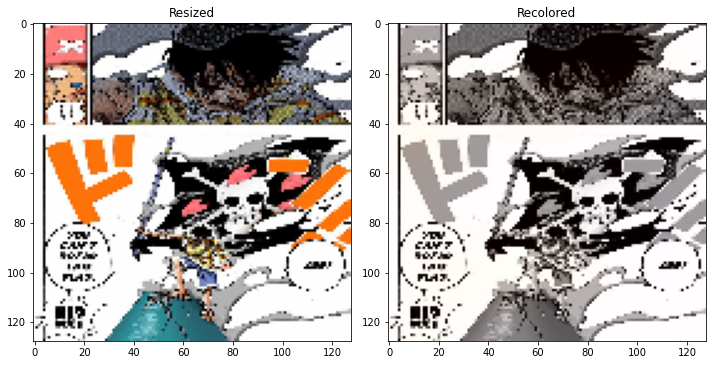

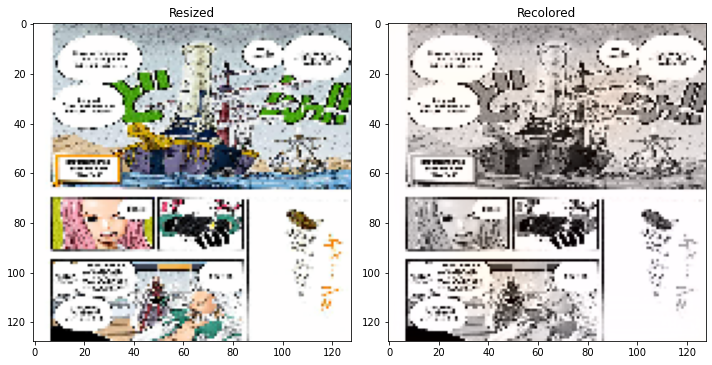

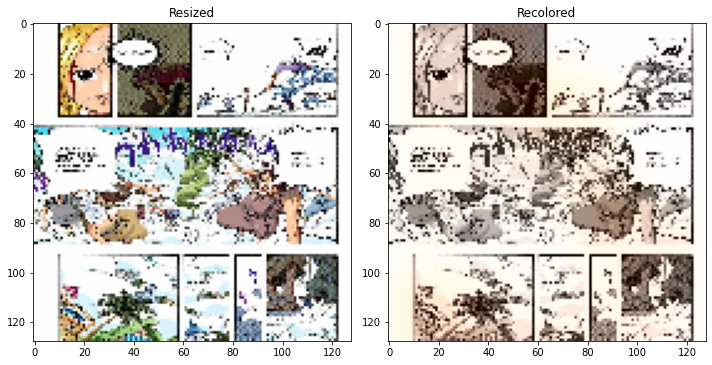

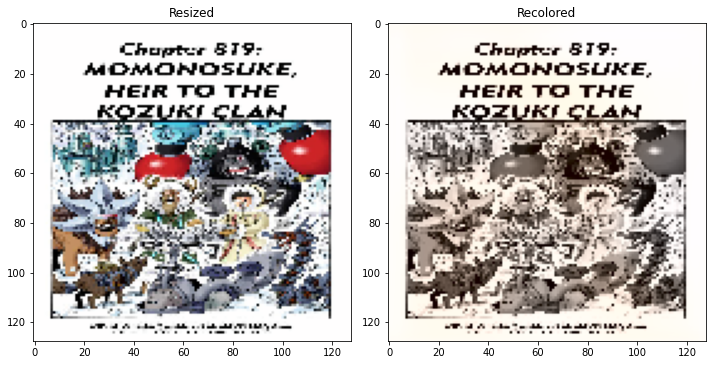

In [120]:
for i, x in enumerate(X_test[:10]):     
    
    img_color = []
    img_color.append(x)
    img_color = np.array(img_color, dtype=float)

    output = model.predict(img_color)
    output = output*128
    
    result = np.zeros((SIZE, SIZE, 3))
    result[:,:,0] = img_color[0][:,:,0]
    result[:,:,1:] = output[0]

    recolored = lab2rgb(result)
    
    original = np.zeros((SIZE, SIZE, 3))
    original[:,:,0] = x[:,:,0]
    original[:,:,1:] = Y_test[i]*128
    
    original = lab2rgb(original)
    
    plot_comparison(original, recolored)

### Visualization with raw images

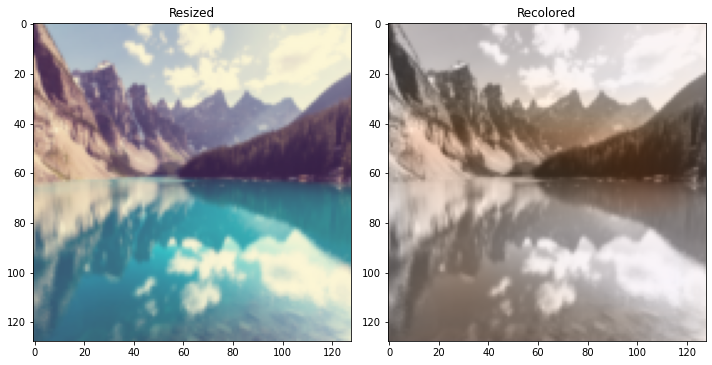

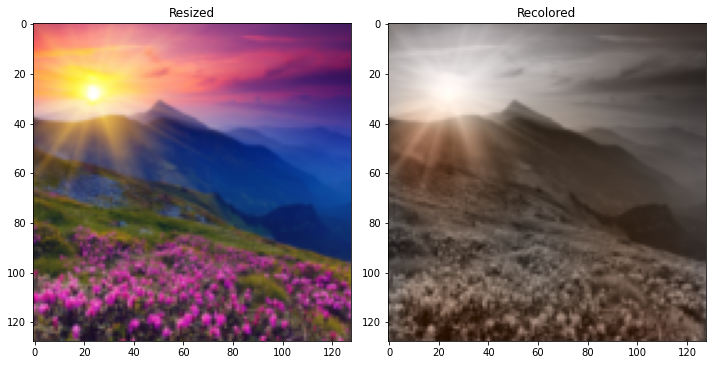

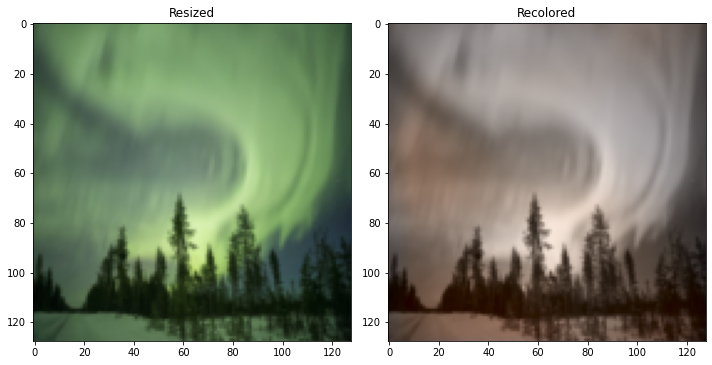

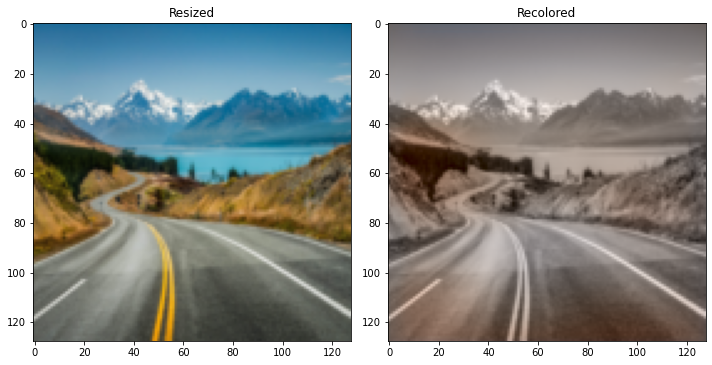

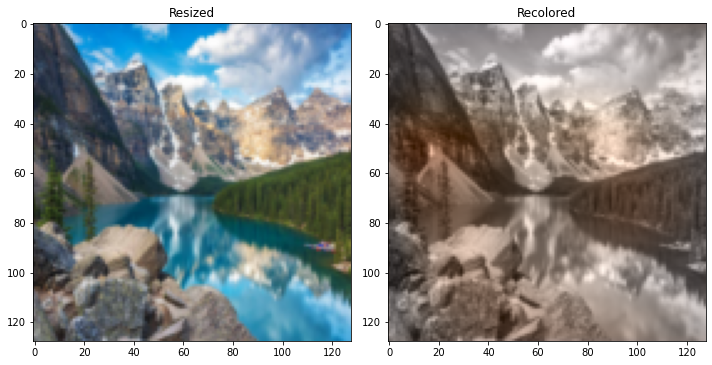

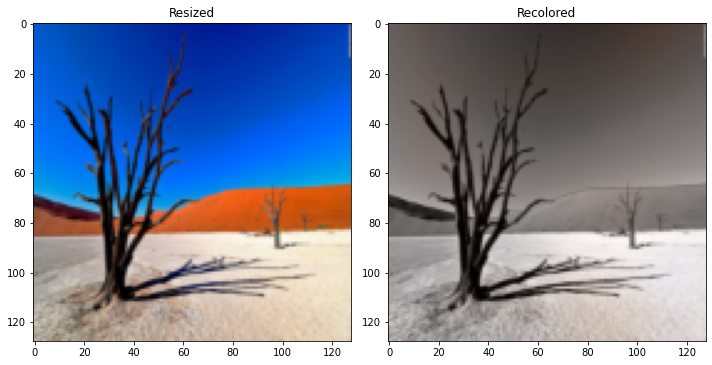

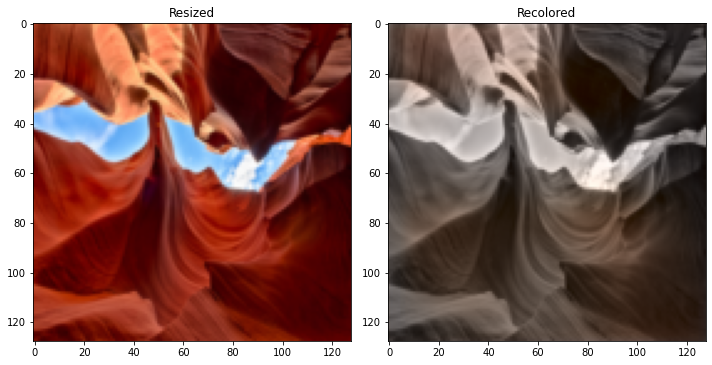

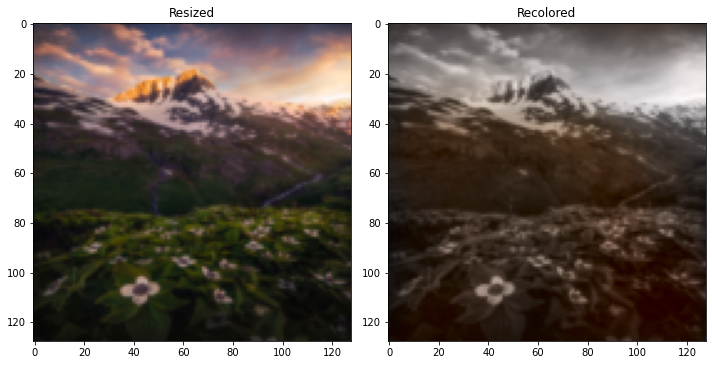

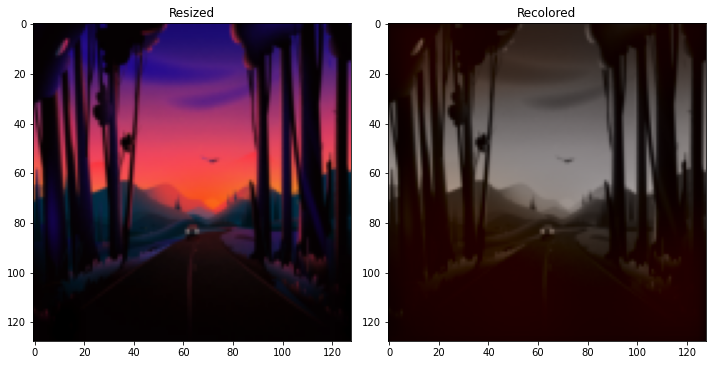

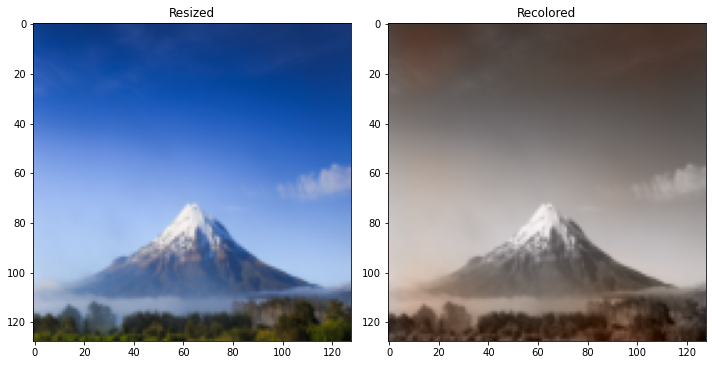

In [121]:
visualization_path = path+"download/landscapes1k/" # modify here to load images from a different folder

for img_path in os.listdir(visualization_path)[:10]:    
    
    img_color = []
    img = img_to_array(load_img(visualization_path+img_path))
    img = resize(img, (SIZE,SIZE))
    
    img_color.append(img)
    
    img_color = np.array(img_color, dtype=float)
    img_color = rgb2lab(1.0/255*img_color)[:,:,:,0]
    img_color = img_color.reshape(img_color.shape+(1,))

    output = model.predict(img_color)
    output = output*128
    
    result = np.zeros((SIZE, SIZE, 3))
    result[:,:,0] = img_color[0][:,:,0]
    result[:,:,1:] = output[0]

    recolored = lab2rgb(result)
    # imsave(results_path+img_path, (recolored*255).astype(np.uint8))
    
    plot_comparison(img, recolored,cast=True)

### Visualization of legacy images

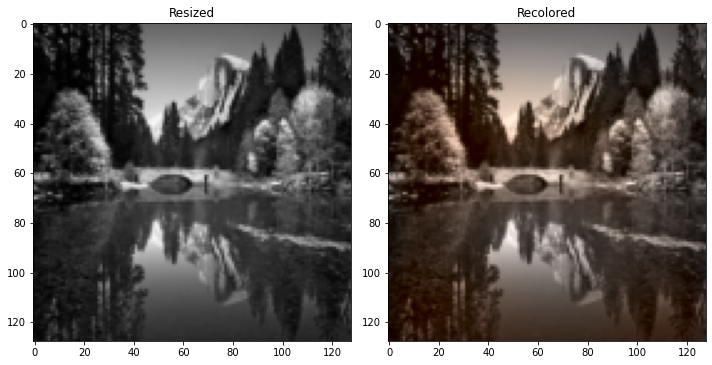

In [122]:
example_path = "../test/" # modify here to load images from a different folder
img_name = "ansel_adams3.jpg"

img_color = []
img = img_to_array(load_img(example_path+img_name))
img = resize(img, (SIZE,SIZE))

img_color.append(img)

img_color = np.array(img_color, dtype=float)
img_color = rgb2lab(1.0/255*img_color)[:,:,:,0]
img_color = img_color.reshape(img_color.shape+(1,))

output = model.predict(img_color)
output = output*128

result = np.zeros((SIZE, SIZE, 3))
result[:,:,0] = img_color[0][:,:,0]
result[:,:,1:] = output[0]

recolored = lab2rgb(result)
# imsave(results_path+img_path, (recolored*255).astype(np.uint8))

fig, axes = plt.subplots(1, 2, figsize=(10,5))
ax = axes.ravel()

ax[0].imshow(img.astype('uint8'))
ax[0].set_title("Resized")

ax[1].imshow(recolored)
ax[1].set_title("Recolored")

fig.tight_layout()
plt.show()      